In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

# add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from lib.functions import *

In [31]:
# load original data frame
df = pd.read_csv("../data/diabetes_prediction_dataset.csv")

### 1. EDA & Data Cleaning

In [32]:
# drop missing values
df=df.loc[df['smoking_history'] != 'No Info']
df=df.loc[df['gender'] != 'Other']

# aggregate values for smoking history
df.loc[df['smoking_history'] == 'not current', 'smoking_history'] = 'former'
df.loc[df['smoking_history'] == 'ever', 'smoking_history'] = 'never'

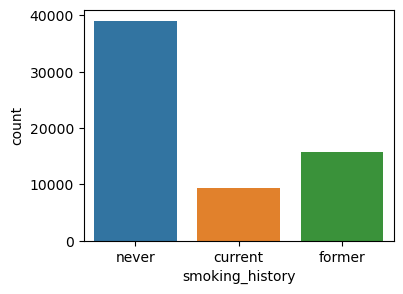

In [33]:
plt.figure(figsize=(4, 3))
sns.countplot(df, x='smoking_history')
plt.show()

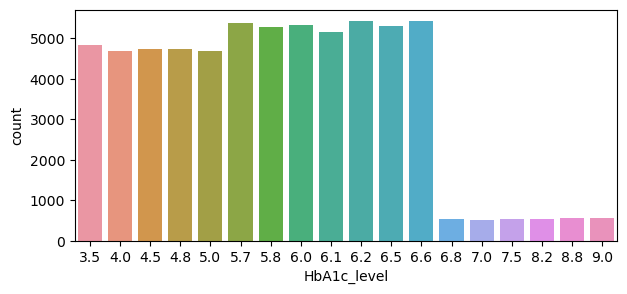

In [23]:
plt.figure(figsize=(7, 3))
sns.countplot(df, x='HbA1c_level')
plt.show()

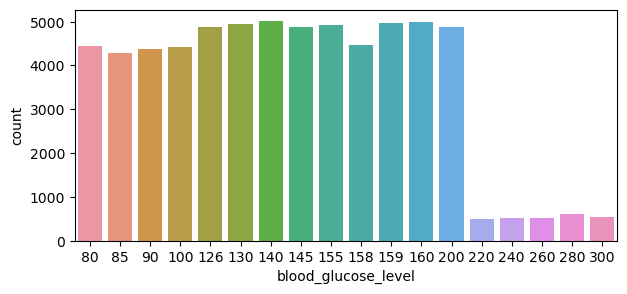

In [20]:
plt.figure(figsize=(7, 3))
sns.countplot(df, x='blood_glucose_level')
plt.show()

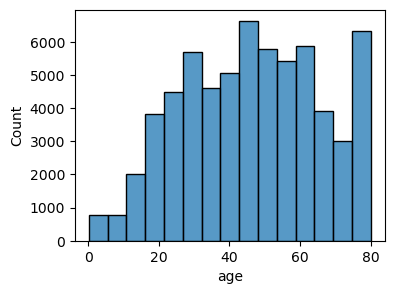

In [17]:
plt.figure(figsize=(4, 3))
sns.histplot(df, x='age', bins=15)
plt.show()

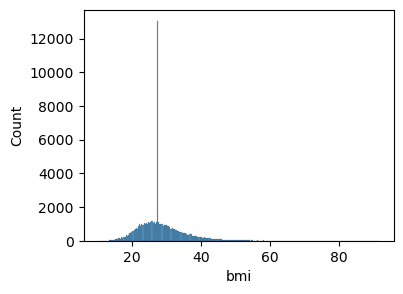

In [24]:
plt.figure(figsize=(4, 3))
sns.histplot(df, x='bmi')
plt.show()

### 2. Feature Engineering

In [10]:
# transform categorical columns to numerical
df["smoking_history"] = df["smoking_history"].map({'never': 0, 'former': 1, 'current': 2})
df["gender"] = df["gender"].map({'Male': 0, 'Female': 1})
df = df.rename(columns={'gender': 'gender_female'})

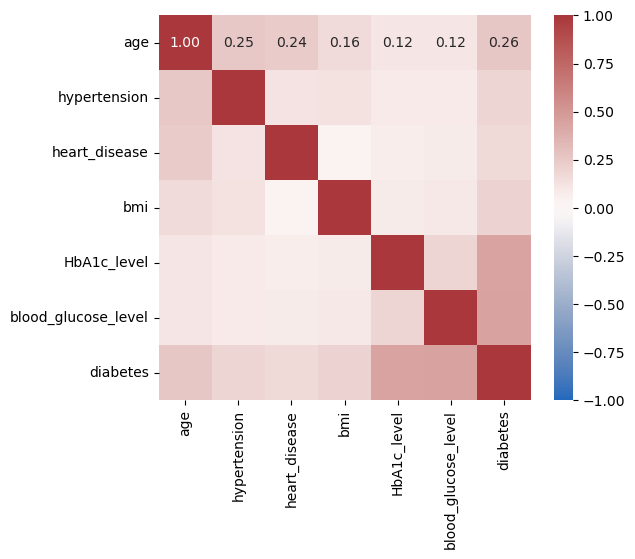

In [15]:
# check for correlation
df_corr = df.corr()
plt.figure(figsize=(6, 5))
sns.heatmap(df_corr, annot=True, vmin = -1, vmax = 1, fmt=".2f", cmap='vlag')
plt.show()

In [12]:
# check for imbalance
df['diabetes'].value_counts()[1] / (df['diabetes'].value_counts()[0] + df['diabetes'].value_counts()[1])

0.10979866608489684

In [13]:
# drop unnecessary columns
df = df.drop(columns = ['smoking_history', 'gender_female'])

### 3. Data Preparation

#### 3.1 Split Data

In [ ]:
# define features and target
features = df.drop(columns = ['diabetes', 'smoking_history', 'gender_female'])
target = df['diabetes']

In [ ]:
# split data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

#### 3.2 Perform Oversampling

In [ ]:
# create additional rows where 'diabetes' == 1

train = X_train.copy()
train['diabetes'] = y_train

diabetes = train.loc[train['diabetes'] == 1]
no_diabetes = train.loc[train['diabetes'] == 0]

from sklearn.utils import resample
diabetes_oversampled = resample(diabetes, replace=True, n_samples = train['diabetes'].value_counts()[0], random_state=42)
train_oversampled = pd.concat([diabetes_oversampled, no_diabetes])

X_train = train_oversampled.drop(columns = ['diabetes'])
y_train = train_oversampled['diabetes']

#### 3.3 Perform Normalization

In [ ]:
# normalize features

from sklearn.preprocessing import StandardScaler
normalizer = StandardScaler()

X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

pd.DataFrame(X_train_norm).head(3)

### 4. Model Training and Evaluation

In [ ]:
# import models

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

#### 4.1 Test different Model Types

In [ ]:
# define model types
models_dict = {
  'Random Forest n=100 depth=10': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
  'Adaptive Boosting Logistic Regression n=100': AdaBoostClassifier(LogisticRegression(), n_estimators=100),
  'Gradient Boosting n=100 depth=10': GradientBoostingClassifier(max_depth=10, n_estimators=100),
  'Logistic Regression': LogisticRegression(),
  'Bagging Logistic Regression n=100': BaggingClassifier(LogisticRegression(), n_estimators=100),
  'Pasting Logistic Regression n=100': BaggingClassifier(LogisticRegression(), n_estimators=100, bootstrap=False),
  'KNN': KNeighborsClassifier(),
  'Bagging KNN n=100': BaggingClassifier(KNeighborsClassifier(), n_estimators=100),
  'Pasting KNN n=100': BaggingClassifier(KNeighborsClassifier(), n_estimators=100, bootstrap=False),
  'SVC': SVC(),
  'Bagging SVC n=100': BaggingClassifier(SVC(), n_estimators=100),
  'Pasting SVC n=100': BaggingClassifier(SVC(), n_estimators=100, bootstrap=False),
}

# train and evaluate model types
df_result = model_testing(X_train, X_test, y_train, y_test, models_dict)

#### 4.2 Hyperparameter Tuning

In [ ]:
# define model types
models_dict = {'RandomForestClassifier': RandomForestClassifier,
              'GradientBoostingClassifier': GradientBoostingClassifier}

# define hyperparameters
n_estimators_grid = [100, 200, 300]
max_depth_grid = [5, 10, 15, 20, 25, 30, 35, 40, 45]

# run and evaluate grid search
df_result = hyperparameter_tuning(X_train, X_test, y_train, y_test, models_dict, n_estimators_grid, max_depth_grid)

In [ ]:
# save model test results to csv file
df_result.to_csv('../data/testing/hyperparameter_with_oversampling.csv', index=False, encoding='utf-8')

In [ ]:
sns.lineplot(df_result, x='max_depth', y='sensitivity', hue='Model Type', style='n_estimators')